In [1]:
import os

os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [2]:
!curl ipinfo.io/json

{
  "ip": "192.243.123.190",
  "hostname": "192.243.123.190.16clouds.com",
  "city": "Osaka",
  "region": "Ōsaka",
  "country": "JP",
  "loc": "34.6938,135.5011",
  "org": "AS25820 IT7 Networks Inc",
  "postal": "543-0062",
  "timezone": "Asia/Tokyo",
  "readme": "https://ipinfo.io/missingauth"
}

In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# 设置设备为cuda,如果可用,否则为cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据
train_data = pd.read_csv('/root/autodl-tmp/heartbeatclassification/train.csv')
test_data = pd.read_csv('/root/autodl-tmp/heartbeatclassification/testA.csv')

# 数据分析与可视化
print("训练集形状:", train_data.shape)
print("测试集形状:", test_data.shape)

print("训练集标签分布:")
print(train_data['label'].value_counts())

训练集形状: (100000, 3)
测试集形状: (20000, 2)
训练集标签分布:
label
0.0    64327
3.0    17912
2.0    14199
1.0     3562
Name: count, dtype: int64


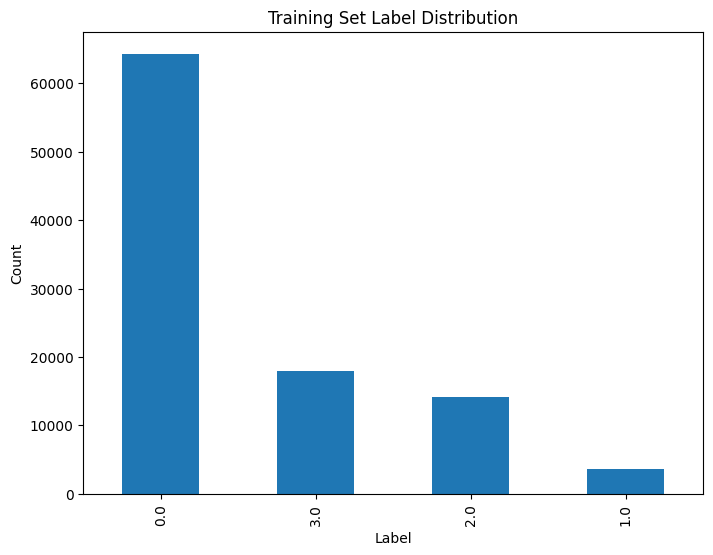

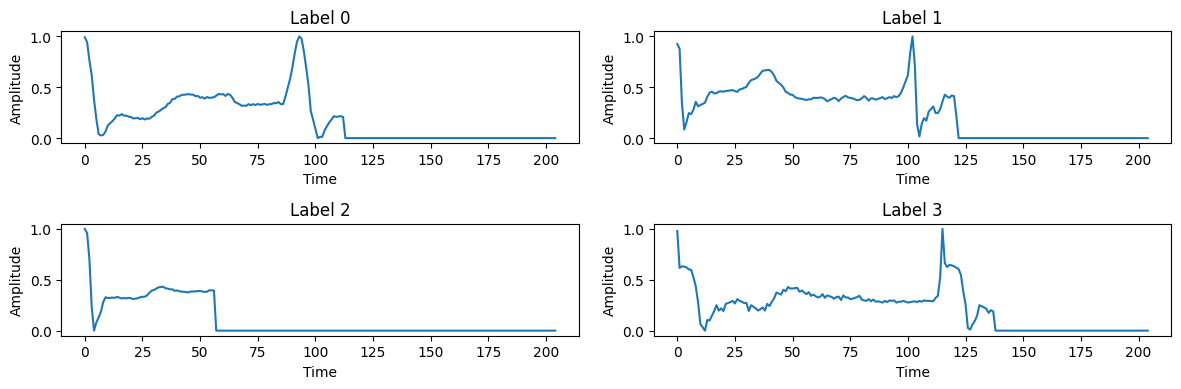

In [4]:
# 绘制训练集标签分布条形图
plt.figure(figsize=(8, 6))
train_data['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Training Set Label Distribution')
plt.show()

# 训练数据中每个标签（label 0, 1, 2, 3）的第一个心跳信号序列的波形图
plt.figure(figsize=(12, 4))
for i in range(4):
    signal = train_data[train_data['label'] == i]['heartbeat_signals'].values[0]
    signal = np.array(signal.split(','), dtype=np.float32)
    plt.subplot(2, 2, i+1)
    plt.plot(signal)
    plt.title(f'Label {i}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [5]:
# 数据预处理
class HeartbeatDataset(Dataset):
    # 初始化HeartbeatDataset类
    # 参数:
    # data (DataFrame): 包含心跳信号和标签的数据框
    # mode (str): 数据集的模式,可以是'train'或'test'。默认为'train'
    def __init__(self, data, mode='train'):
        self.data = data
        self.mode = mode

        if self.mode == 'train':
            self.labels = data['label'].values.astype(int)

        self.signals = data['heartbeat_signals'].apply(lambda x: np.array(x.split(','), dtype=np.float32))
    
    # 返回数据集的长度
    def __len__(self):
        return len(self.data)
    
    # 根据给定的索引获取数据样本
    # 参数:
    # idx (int): 要获取的数据样本的索引
    # 返回:
    # 如果mode为'train',返回信号张量和对应的标签
    # 如果mode为'test',仅返回信号张量
    def __getitem__(self, idx):
        signal = self.signals.iloc[idx]
        signal = np.expand_dims(signal, axis=0)  # 增加一个维度,使其形状变为 (1, sequence_length)
        signal = torch.from_numpy(signal).float()  # 将NumPy数组转换为PyTorch张量,数据类型为float32

        if self.mode == 'train':
            label = self.labels[idx]
            return signal, label
        else:
            return signal


# 创建数据集和数据加载器
train_dataset = HeartbeatDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [6]:
# 定义CNN模型
class HeartbeatClassifier(nn.Module):
    # 定义了模型的各个层和组件
    # 在 Python 中,__init__ 是一个特殊的方法,称为构造函数或初始化方法
    def __init__(self):
        super(HeartbeatClassifier, self).__init__()
        # 四个一维卷积层
        # 每个卷积层的参数包括:输入通道数(in_channels),输出通道数(out_channels),卷积核大小(kernel_size),步长(stride)和填充(padding)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        # 一维最大池化层(MaxPool1d),用于降低信号的空间维度,提取最显著的特征
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        # 一个带有负斜率的 LeakyReLU 激活函数,用于引入非线性特征
        self.sleakyrelu = nn.LeakyReLU(negative_slope=0.05)
        # 四个一维批归一化层(BatchNorm1d),分别应用于卷积层的输出
        # 批归一化有助于加速模型的收敛,并提高模型的泛化能力
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(256)
        # 一个 Dropout 层,用于随机关闭一部分神经元,减少过拟合
        self.dropout = nn.Dropout(0.2)
        # 一个由三个全连接层(Linear)组成的序列
        # 第一个全连接层将卷积层的输出展平并映射到4096维,然后经过批归一化和 LeakyReLU 激活函数
        # 第二个全连接层将4096维映射到64维,然后经过批归一化和 LeakyReLU 激活函数
        # 第三个全连接层将64维映射到4维,对应于4个心跳信号类别
        self.linear = nn.Sequential(
            nn.Linear(256 * 25, 4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Linear(4096, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Linear(64, 4)
        )
        
    # 定义了模型的前向传播过程,即数据如何通过模型的各个层进行处理
    def forward(self, x):
        # 输入数据 x 首先通过第一个卷积层 self.conv1,然后经过批归一化 self.bn1 和 LeakyReLU 激活函数 self.sleakyrelu
        # 接着,数据通过最大池化层 self.maxpool 进行下采样
        # 然后,数据依次通过第二个卷积层 self.conv2、批归一化 self.bn2、LeakyReLU 激活函数和最大池化层
        # 类似地,数据通过第三个和第四个卷积层、批归一化、LeakyReLU 激活函数和最大池化层
        # 经过卷积层后,数据通过 Dropout 层 self.dropout 进行正则化
        # 然后,数据被展平(torch.flatten),并通过全连接层 self.linear 进行最终的分类预测
        # 最后,模型返回预测的类别概率
        x = self.bn1(self.conv1(x))
        x = self.sleakyrelu(x)
        x = self.maxpool(x)
        
        x = self.bn2(self.conv2(x))
        x = self.sleakyrelu(x)
        x = self.maxpool(x)
        
        x = self.bn3(self.conv3(x))
        x = self.sleakyrelu(x)
        
        x = self.bn4(self.conv4(x))
        x = self.sleakyrelu(x)
        
        x = self.maxpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

In [7]:
# 训练模型
# 首先，通过实例化 HeartbeatClassifier 类来创建 CNN 模型,并将其移动到指定的设备(CPU 或 GPU)上
model = HeartbeatClassifier().to(device)
# 然后,定义损失函数 criterion 为交叉熵损失函数(nn.CrossEntropyLoss),用于衡量模型的预测与真实标签之间的差异
criterion = nn.CrossEntropyLoss()
# 接着,定义优化器 optimizer 为 Adam 优化器(torch.optim.Adam),用于更新模型的参数。优化器的学习率设置为0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 设置学习率调度器，用于在训练过程中动态调整学习率
# 这里使用的是 StepLR 调度器,它会在每个指定的 step_size 个 epoch 后,将学习率乘以 gamma 参数
# 在这个例子中,每100个 epoch,学习率会减少到原来的0.5倍
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

num_epochs = 500
train_losses = []

# 训练过程通过一个循环进行,循环的次数由 num_epochs 指定
for epoch in range(num_epochs):
    # 在每个 epoch 开始时,将模型设置为训练模式(model.train())
    # 然后,使用 train_loader 进行小批量训练。每个小批量包含信号数据 signals 和对应的标签 labels
    model.train()
    running_loss = 0.0

    for signals, labels in train_loader:
        # 将信号数据和标签移动到指定的设备上
        signals, labels = signals.to(device), labels.to(device)
        # 清零优化器的梯度
        optimizer.zero_grad()
        # 将信号数据输入到模型中,得到预测输出
        outputs = model(signals)
        # 计算预测输出和真实标签之间的损失
        loss = criterion(outputs, labels)
        # 通过反向传播计算梯度
        loss.backward()
        # 使用优化器更新模型的参数
        optimizer.step()
        # 累加损失值
        running_loss += loss.item()

    # 计算该 epoch 的平均损失值 epoch_loss,并将其添加到 train_losses 列表中
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    # 打印当前 epoch 的信息,包括 epoch 编号和平均损失值
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # 调用学习率调度器的 step() 方法,根据设定的策略调整学习率
    scheduler.step()

/root/anaconda3/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/500], Loss: 0.2611
Epoch [2/500], Loss: 0.0912
Epoch [3/500], Loss: 0.0522
Epoch [4/500], Loss: 0.0355
Epoch [5/500], Loss: 0.0265
Epoch [6/500], Loss: 0.0198
Epoch [7/500], Loss: 0.0165
Epoch [8/500], Loss: 0.0137
Epoch [9/500], Loss: 0.0114
Epoch [10/500], Loss: 0.0091
Epoch [11/500], Loss: 0.0087
Epoch [12/500], Loss: 0.0072
Epoch [13/500], Loss: 0.0065
Epoch [14/500], Loss: 0.0073
Epoch [15/500], Loss: 0.0054
Epoch [16/500], Loss: 0.0063
Epoch [17/500], Loss: 0.0046
Epoch [18/500], Loss: 0.0034
Epoch [19/500], Loss: 0.0052
Epoch [20/500], Loss: 0.0052
Epoch [21/500], Loss: 0.0036
Epoch [22/500], Loss: 0.0027
Epoch [23/500], Loss: 0.0041
Epoch [24/500], Loss: 0.0031
Epoch [25/500], Loss: 0.0024
Epoch [26/500], Loss: 0.0025
Epoch [27/500], Loss: 0.0034
Epoch [28/500], Loss: 0.0029
Epoch [29/500], Loss: 0.0027
Epoch [30/500], Loss: 0.0037
Epoch [31/500], Loss: 0.0023
Epoch [32/500], Loss: 0.0016
Epoch [33/500], Loss: 0.0024
Epoch [34/500], Loss: 0.0018
Epoch [35/500], Loss: 0

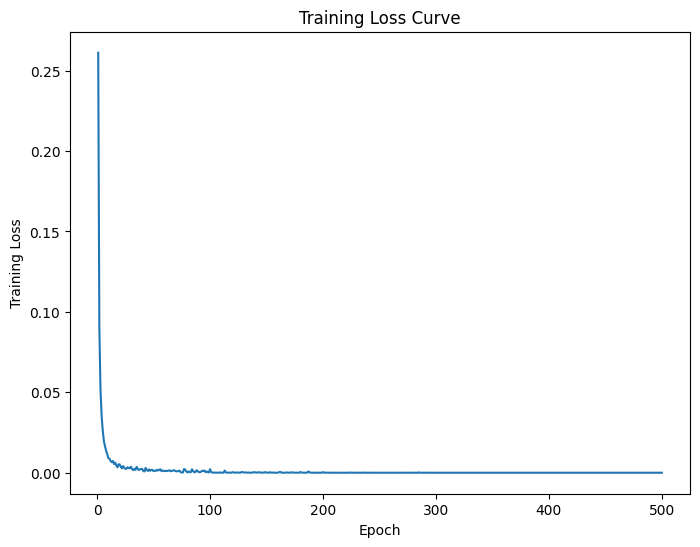

In [8]:
# 绘制训练损失曲线
plt.figure(figsize=(8, 6))
# 使用 plt.plot() 函数绘制训练损失曲线,其中 range(1, num_epochs+1) 表示横坐标的范围,train_losses 是纵坐标的数据
plt.plot(range(1, num_epochs+1), train_losses)
# 使用 plt.xlabel()、plt.ylabel() 和 plt.title() 分别设置横坐标标签、纵坐标标签和图形标题
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

In [9]:
# 使用 torch.save() 函数将训练好的模型的状态字典保存到指定路径。状态字典包含了模型的参数和缓存等信息
torch.save(model.state_dict(), '/root/heartbeatclassification/models/heartbeat_classifier_model_state_24_06_15_3.pth')

In [10]:
# 加载模型时,首先创建一个新的 HeartbeatClassifier 实例,然后使用 model.load_state_dict() 函数从保存的状态字典中加载模型的参数
model = HeartbeatClassifier().to(device)
model.load_state_dict(torch.load('/root/heartbeatclassification/models/heartbeat_classifier_model_state_24_06_15_3.pth'))
# 使用 model.eval() 将模型设置为评估模式,这会关闭某些层的训练行为,如 Dropout 和 BatchNorm
model.eval()

HeartbeatClassifier(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sleakyrelu): LeakyReLU(negative_slope=0.05)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, t

In [11]:
# 创建测试数据集 test_dataset 和数据加载器 test_loader,用于加载测试数据
test_dataset = HeartbeatDataset(test_data, mode='test')
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

predictions = []

# 使用 torch.no_grad() 上下文管理器关闭梯度计算,以减少内存的使用
with torch.no_grad():
    # 遍历测试数据加载器,将每个批次的信号数据 signals 移动到指定的设备上
    for signals in test_loader:
        signals = signals.to(device)
        # 将信号数据输入到模型中,得到预测输出 outputs
        outputs = model(signals)
        # 对预测输出应用 softmax 函数,得到每个类别的概率 probs,并将其转换为 NumPy 数组
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        
        # 概率优化处理
        # 对概率进行优化处理,将小于0.1的概率置为0,大于0.9的概率置为1
        probs[probs < 0.1] = 0
        probs[probs > 0.9] = 1

        # 将概率结果添加到 predictions 列表中
        # 在这个例子中,probs 是一个 NumPy 数组,包含了当前批次中所有样本的概率值
        # 使用 extend() 方法可以将 probs 中的所有元素添加到 predictions 列表中,而不是将整个 probs 数组作为一个单独的元素添加
        predictions.extend(probs)
        
# 创建一个 DataFrame submission,包含测试数据的 ID 和每个类别的预测概率
# 使用列表推导式将 predictions 中的概率值分别赋给对应的列
submission = pd.DataFrame({
    'id': test_data['id'],
    'label_0': [pred[0] for pred in predictions],
    'label_1': [pred[1] for pred in predictions],
    'label_2': [pred[2] for pred in predictions],
    'label_3': [pred[3] for pred in predictions]
})

# 使用 submission.to_csv() 函数将 DataFrame 保存为 CSV 文件,指定输出路径和写入模式
submission.to_csv('/root/heartbeatclassification/results/submission_24_06_15_3.csv', index=False, mode='w')